In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import time
import sys
import pytorch_model_summary
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm


print(f'torch : {torch.__version__}')
print(f'python : {sys.version}')

torch : 1.11.0
python : 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]


In [13]:

class ImageData(Dataset):
    def __init__(self,path,transform=None,target_transform=None):
        self.path = path
        self.files =[]
        self.labels = []
        for i in os.listdir(path):
            if i[:-3]+'png' in os.listdir(path+'/label'):
                self.files.append(i)
                self.labels.append(i[:-3]+'png')
        self.transform = transform
        self.target_transform = target_transform
        
    def __getitem__(self,idx):
        img = Image.open(self.path+'/'+self.files[idx])
        label = Image.open(self.path+'/label/'+self.labels[idx])
        #img = np.array(img)[:,:256]
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            label = self.target_transform(label)
        return img, label

    def __len__(self):
        return len(self.files)

class ConvertToBackground(object):
    def __call__(self, img):
        img = np.asarray(img,dtype=np.uint8)
        img[img==255] = 0
        # 64bit 부호 정수 long 타입 Tensor로 변환 
        img = torch.from_numpy(img).long()
        return img


In [14]:
data_mean = [0.485, 0.456, 0.406]
data_std = [0.229, 0.224, 0.225]

transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomCrop((224,224)),
        #transforms.RandomAffine(degrees=15),
        # PIL 타입의 [0,255] data를 [0,1]의 FloatTensor로 변환
        transforms.ToTensor(),
        transforms.Normalize(mean=data_mean,std=data_std)
    ]
)
val_transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=data_mean,std=data_std)
    ]
)
label_transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        # 경계를 배경으로 처리
        ConvertToBackground()
    ]
)

batch_size = 4
train_path = './data/train'
train_set = ImageData(train_path,transform,label_transform)
#train_set = torchvision.datasets.VOCSegmentation(root='./data', year='2012',\
#    image_set='train',download=False,transform=transform,target_transform=label_transform)
train_loader = DataLoader(train_set, batch_size= batch_size,shuffle=True)
val_path = './data/val'
val_set = ImageData(val_path,val_transform,label_transform)
#val_set = torchvision.datasets.VOCSegmentation(root='./data', year='2012',\
#    image_set='val',download=False,transform=transform,target_transform=label_transform)
val_loader = DataLoader(val_set, batch_size= batch_size,shuffle=True)


In [15]:
#a,b = train_set[0]
#print(a.shape)

print(len(train_loader))
#temp_img,temp_label = next(iter(train_loader))
#print(temp_img)

366


In [16]:
# 사전에 학습된 vgg16 parameter 가져오기
vgg16 = torchvision.models.vgg16(pretrained=True)
#for param in vgg16.features.parameters():
#   param.requires_grad = False

In [17]:
class FCN32(nn.Module):
    # vgg 16 
    def __init__(self,num_class):
        super(FCN32, self).__init__()
        self.vgg16 = vgg16.features
        # self.conv1 = self.make_block(in_channel=3, out_channel=64,repeat=2)
        # self.conv2 = self.make_block(in_channel=64,out_channel=128,repeat=2)
        # self.conv3 = self.make_block(128,256,3)
        # self.conv4 = self.make_block(256,512,3)
        # self.conv5 = self.make_block(512,512,3)

        self.fc1 = nn.Conv2d(in_channels=512,out_channels=4096,kernel_size=7)
        self.fc2 = nn.Conv2d(4096,4096,kernel_size=1)
        self.fc3 = nn.Conv2d(4096,num_class,kernel_size=1)

        self.upsample32 = nn.ConvTranspose2d(num_class,num_class,kernel_size=224,stride=32)
        #self.upsample32 = nn.Upsample(scale_factor=32,mode='bilinear')
        #self._initialize_weights()

    def forward(self, x):

        x = self.vgg16(x)
        x = self.fc1(x)
        x = nn.ReLU(True)(x)
        x = nn.Dropout2d(0.5)(x)
        x = self.fc2(x)
        x = nn.ReLU(True)(x)
        x = nn.Dropout2d(0.5)(x)
        x = self.fc3(x)
        x = self.upsample32(x)
        #print(x.shape)
        return x
        

    # def _initialize_weights(self):
    #     for m in self.modules():
    #         print(m)
    #         if isinstance(m, nn.Conv2d):
    #             m.weight.data.zero_()
    #             if m.bias is not None:
    #                 m.bias.data.zero_()
    # def make_block(self, in_channel, out_channel, repeat):
    #     layers = []
    #     for i in range(repeat):
    #         if (i==0):
    #             layers.append(nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1, stride=1))
    #         else:
    #             layers.append(nn.Conv2d(out_channel,out_channel,kernel_size=3, padding=1, stride=1))
    #         layers.append(nn.BatchNorm2d(out_channel))
    #         layers.append(nn.ReLU())
    #     layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    #     block = nn.Sequential(*layers)

    #     return block

In [18]:
FCN =FCN32(num_class=21)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
#print(FCN)
print(pytorch_model_summary.summary(FCN,torch.zeros(batch_size,3,224,224),show_input=True))

Using cuda device
-----------------------------------------------------------------------------
         Layer (type)            Input Shape         Param #     Tr. Param #
             Conv2d-1       [4, 3, 224, 224]           1,792           1,792
               ReLU-2      [4, 64, 224, 224]               0               0
             Conv2d-3      [4, 64, 224, 224]          36,928          36,928
               ReLU-4      [4, 64, 224, 224]               0               0
          MaxPool2d-5      [4, 64, 224, 224]               0               0
             Conv2d-6      [4, 64, 112, 112]          73,856          73,856
               ReLU-7     [4, 128, 112, 112]               0               0
             Conv2d-8     [4, 128, 112, 112]         147,584         147,584
               ReLU-9     [4, 128, 112, 112]               0               0
         MaxPool2d-10     [4, 128, 112, 112]               0               0
            Conv2d-11       [4, 128, 56, 56]         295,

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(FCN.parameters(), lr=0.00005)

In [20]:
def pixel_accuracy(output, label):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1),dim=1)
        correct = torch.eq(output, label).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy
# https://sanghyu.tistory.com/3 -- view, contiguous
def mIoU(output, label,num_classes=21):
    with torch.no_grad():
        output = F.softmax(output, dim=1)
        output = torch.argmax(output, dim=1)
        # 메모리에 저장된 순서를 하나씩, view할때 섞이지 않도록
        output = output.contiguous().view(-1)
        label = label.contiguous().view(-1)
    
        iou_class = []
        for c in range(0, num_classes):
            output_true = output==c
            label_true = label==c

            if label_true.long().sum().item() == 0:
                iou_class.append(np.nan)
            else:
                intersect = torch.logical_and(output_true,label_true).sum().float().item()
                union = torch.logical_or(output_true,label_true).sum().float().item()
                iou= intersect/union
                iou_class.append(iou)
        return np.nanmean(iou_class)

def get_lr(optim):
    for param_group in optim.param_groups:
        return param_group['lr']

In [21]:
# 학습
FCN.to(device)
epochs= 50
best_loss = 0
train_loss_list = []
train_acc_list = []
train_iou_list = []
val_loss_list = []
val_acc_list = []
val_iou_list = []
min_miou = 0
lrs = []
for epoch in range(epochs):
    val_running_loss = 0
    train_running_loss =0
    start_time = time.time()
    train_iou_score = 0
    val_iou_score =0
    train_acc = 0
    val_acc = 0

    FCN.train()
    for iter,data in tqdm(enumerate(train_loader)):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = FCN(inputs)
        # print(f'input shape : {inputs.shape}')
        # print(f'output shape : {outputs[0][0].shape}')
        # print(f'output  --{outputs[0][0]}')
        # print(f'labels shape : {labels.shape}')
        # print(f'lable --{labels[labels>0]}')
        loss = criterion(outputs,labels) 
        loss.backward()
        optimizer.step()

        train_iou_score += mIoU(outputs, labels)
        train_acc += pixel_accuracy(outputs, labels)
        train_running_loss += loss.item()
    
    FCN.eval()
    with torch.no_grad():
        for iter, vdata in tqdm(enumerate(val_loader)):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.to(device)

            voutputs = FCN(vinputs)
            vloss = criterion(voutputs,vlabels)

            val_running_loss += vloss.item()
            val_iou_score += mIoU(voutputs,vlabels)
            val_acc += pixel_accuracy(voutputs,vlabels)


        train_running_loss /= len(train_loader)
        train_iou_score /=len(train_loader)
        train_acc /=len(train_loader)
        val_running_loss /= len(val_loader)
        val_iou_score /=len(val_loader)
        val_acc /=len(val_loader)
        lrs.append(get_lr(optimizer))

        print(f'{epoch+1} epcoh , time = {time.time()-start_time:.2f}')
        print(f'train loss : {train_running_loss:.5f}, val_loss : {val_running_loss:.5f}')
        print(f'train IoU : {train_iou_score:.5f}, val IoU : {val_iou_score:.5f}')
        print(f'train Acc : {train_acc:.5f}, val Acc : {val_acc:.5f}')
        train_loss_list.append(train_running_loss)
        train_iou_list.append(train_iou_score)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_running_loss)
        val_iou_list.append(val_iou_score)
        val_acc_list.append(val_acc)

        if min_miou < val_iou_score:
            min_miou = val_iou_score
            #print('save model')
            torch.save(FCN, './models/FCN32-Vgg16.pt') 
            
                   
history = {'train_loss': train_loss_list, 'val_loss':val_loss_list,'train_miou': train_iou_list,
'val_miou':val_iou_list,'train_acc':train_acc_list,'val_acc':val_acc_list, 'lr':lrs}
print('Finish Training')

366it [01:00,  6.04it/s]
363it [00:20, 17.85it/s]


1 epcoh , time = 80.91
train loss : 1.32236, val_loss : 1.16918
train IoU : 0.12880, val IoU : 0.13060
train Acc : 0.74227, val Acc : 0.74810


366it [00:59,  6.10it/s]
363it [00:20, 17.82it/s]


2 epcoh , time = 80.37
train loss : 1.15305, val_loss : 1.15767
train IoU : 0.12869, val IoU : 0.12995
train Acc : 0.74891, val Acc : 0.74791


366it [01:00,  6.06it/s]
363it [00:20, 17.82it/s]


3 epcoh , time = 80.79
train loss : 1.02898, val_loss : 1.00028
train IoU : 0.14713, val IoU : 0.15630
train Acc : 0.75152, val Acc : 0.75147


366it [01:00,  6.06it/s]
363it [00:20, 17.76it/s]


4 epcoh , time = 80.86
train loss : 0.95067, val_loss : 0.98123
train IoU : 0.16130, val IoU : 0.16616
train Acc : 0.75534, val Acc : 0.75395


366it [01:00,  6.02it/s]
363it [00:20, 17.63it/s]


5 epcoh , time = 81.40
train loss : 0.91379, val_loss : 0.97783
train IoU : 0.16560, val IoU : 0.15284
train Acc : 0.75971, val Acc : 0.75571


366it [01:00,  6.03it/s]
363it [00:21, 17.09it/s]


6 epcoh , time = 81.90
train loss : 0.83459, val_loss : 0.86347
train IoU : 0.18975, val IoU : 0.19111
train Acc : 0.76989, val Acc : 0.76803


366it [01:00,  6.06it/s]
363it [00:21, 17.20it/s]


7 epcoh , time = 81.52
train loss : 0.77739, val_loss : 0.86242
train IoU : 0.20776, val IoU : 0.21148
train Acc : 0.77600, val Acc : 0.76860


366it [01:00,  6.05it/s]
363it [00:20, 17.59it/s]


8 epcoh , time = 81.11
train loss : 0.72984, val_loss : 0.80640
train IoU : 0.22254, val IoU : 0.20224
train Acc : 0.78213, val Acc : 0.77571


366it [01:00,  6.00it/s]
363it [00:20, 17.82it/s]


9 epcoh , time = 81.36
train loss : 0.68068, val_loss : 0.77801
train IoU : 0.24185, val IoU : 0.22787
train Acc : 0.78965, val Acc : 0.78013


366it [01:01,  5.97it/s]
363it [00:20, 17.84it/s]


10 epcoh , time = 81.67
train loss : 0.62895, val_loss : 0.78351
train IoU : 0.26531, val IoU : 0.20726
train Acc : 0.79919, val Acc : 0.77773


366it [01:00,  6.03it/s]
363it [00:20, 17.86it/s]


11 epcoh , time = 81.07
train loss : 0.57928, val_loss : 0.73615
train IoU : 0.28372, val IoU : 0.23385
train Acc : 0.80781, val Acc : 0.78454


366it [01:03,  5.73it/s]
363it [00:21, 16.71it/s]


12 epcoh , time = 85.60
train loss : 0.54152, val_loss : 0.70949
train IoU : 0.30293, val IoU : 0.25801
train Acc : 0.81489, val Acc : 0.78953


366it [01:06,  5.49it/s]
363it [00:20, 17.82it/s]


13 epcoh , time = 87.01
train loss : 0.50491, val_loss : 0.69327
train IoU : 0.32361, val IoU : 0.25707
train Acc : 0.82479, val Acc : 0.79375


366it [01:00,  6.04it/s]
363it [00:20, 17.52it/s]


14 epcoh , time = 81.34
train loss : 0.47399, val_loss : 0.67895
train IoU : 0.34084, val IoU : 0.28119
train Acc : 0.83301, val Acc : 0.79866


366it [01:00,  6.07it/s]
363it [00:20, 17.63it/s]


15 epcoh , time = 80.94
train loss : 0.44493, val_loss : 0.69708
train IoU : 0.36451, val IoU : 0.28158
train Acc : 0.84133, val Acc : 0.79506


366it [01:01,  5.98it/s]
363it [00:20, 17.44it/s]


16 epcoh , time = 82.07
train loss : 0.42534, val_loss : 0.72109
train IoU : 0.38149, val IoU : 0.29013
train Acc : 0.84791, val Acc : 0.79725


366it [01:00,  6.05it/s]
363it [00:20, 17.87it/s]


17 epcoh , time = 80.84
train loss : 0.39934, val_loss : 0.67253
train IoU : 0.39887, val IoU : 0.30216
train Acc : 0.85660, val Acc : 0.80073


366it [01:04,  5.69it/s]
363it [00:22, 15.96it/s]


18 epcoh , time = 87.04
train loss : 0.38256, val_loss : 0.69122
train IoU : 0.41007, val IoU : 0.29455
train Acc : 0.86084, val Acc : 0.80143


366it [01:10,  5.23it/s]
363it [00:22, 15.82it/s]


19 epcoh , time = 93.00
train loss : 0.37363, val_loss : 0.65776
train IoU : 0.42091, val IoU : 0.31021
train Acc : 0.86426, val Acc : 0.80405


366it [01:01,  5.93it/s]
363it [00:21, 16.83it/s]


20 epcoh , time = 83.32
train loss : 0.35473, val_loss : 0.67528
train IoU : 0.42953, val IoU : 0.30974
train Acc : 0.86957, val Acc : 0.80497


366it [01:01,  5.97it/s]
363it [00:21, 17.14it/s]


21 epcoh , time = 82.55
train loss : 0.34933, val_loss : 0.67699
train IoU : 0.43845, val IoU : 0.30806
train Acc : 0.87201, val Acc : 0.80654


366it [01:00,  6.05it/s]
363it [00:20, 17.71it/s]


22 epcoh , time = 81.01
train loss : 0.33913, val_loss : 0.65424
train IoU : 0.44182, val IoU : 0.32361
train Acc : 0.87418, val Acc : 0.80593


366it [01:00,  6.02it/s]
363it [00:21, 17.22it/s]


23 epcoh , time = 81.92
train loss : 0.33100, val_loss : 0.66657
train IoU : 0.45485, val IoU : 0.31342
train Acc : 0.87670, val Acc : 0.80789


366it [01:01,  5.95it/s]
363it [00:20, 17.65it/s]


24 epcoh , time = 82.08
train loss : 0.32327, val_loss : 0.65938
train IoU : 0.46020, val IoU : 0.33017
train Acc : 0.87950, val Acc : 0.80391


366it [01:00,  6.07it/s]
363it [00:20, 17.95it/s]


25 epcoh , time = 80.56
train loss : 0.31825, val_loss : 0.69304
train IoU : 0.46020, val IoU : 0.32325
train Acc : 0.88110, val Acc : 0.80320


366it [01:00,  6.01it/s]
363it [00:20, 17.46it/s]


26 epcoh , time = 81.66
train loss : 0.31066, val_loss : 0.65622
train IoU : 0.47456, val IoU : 0.32916
train Acc : 0.88323, val Acc : 0.80878


366it [01:00,  6.04it/s]
363it [00:20, 17.94it/s]


27 epcoh , time = 80.86
train loss : 0.30654, val_loss : 0.67915
train IoU : 0.47453, val IoU : 0.32081
train Acc : 0.88465, val Acc : 0.81290


366it [01:01,  5.96it/s]
363it [00:20, 17.72it/s]


28 epcoh , time = 81.87
train loss : 0.30111, val_loss : 0.65852
train IoU : 0.47486, val IoU : 0.33267
train Acc : 0.88633, val Acc : 0.80792


366it [01:00,  6.02it/s]
363it [00:20, 17.69it/s]


29 epcoh , time = 81.34
train loss : 0.29664, val_loss : 0.70174
train IoU : 0.48035, val IoU : 0.31906
train Acc : 0.88815, val Acc : 0.80871


366it [01:00,  6.01it/s]
363it [00:20, 17.90it/s]


30 epcoh , time = 81.23
train loss : 0.28437, val_loss : 0.69724
train IoU : 0.49434, val IoU : 0.32672
train Acc : 0.89144, val Acc : 0.81085


366it [01:00,  6.00it/s]
363it [00:21, 17.10it/s]


31 epcoh , time = 82.23
train loss : 0.28360, val_loss : 0.65356
train IoU : 0.49858, val IoU : 0.33828
train Acc : 0.89276, val Acc : 0.80758


366it [01:00,  6.03it/s]
363it [00:20, 17.66it/s]


32 epcoh , time = 81.26
train loss : 0.27459, val_loss : 0.66124
train IoU : 0.50136, val IoU : 0.33129
train Acc : 0.89552, val Acc : 0.81382


366it [01:00,  6.05it/s]
363it [00:20, 17.99it/s]


33 epcoh , time = 80.68
train loss : 0.27147, val_loss : 0.69570
train IoU : 0.51101, val IoU : 0.31500
train Acc : 0.89622, val Acc : 0.81037


366it [01:00,  6.03it/s]
363it [00:21, 16.94it/s]


34 epcoh , time = 82.18
train loss : 0.26866, val_loss : 0.64399
train IoU : 0.51981, val IoU : 0.34275
train Acc : 0.89772, val Acc : 0.81491


366it [01:00,  6.07it/s]
363it [00:20, 17.50it/s]


35 epcoh , time = 81.07
train loss : 0.26136, val_loss : 0.67974
train IoU : 0.51936, val IoU : 0.32660
train Acc : 0.89948, val Acc : 0.80759


366it [01:00,  6.07it/s]
363it [00:20, 17.98it/s]


36 epcoh , time = 80.46
train loss : 0.25605, val_loss : 0.66784
train IoU : 0.53329, val IoU : 0.32931
train Acc : 0.90218, val Acc : 0.81344


366it [01:01,  5.99it/s]
363it [00:23, 15.65it/s]


37 epcoh , time = 84.29
train loss : 0.25191, val_loss : 0.69402
train IoU : 0.53152, val IoU : 0.33167
train Acc : 0.90318, val Acc : 0.81227


366it [01:10,  5.18it/s]
363it [00:23, 15.69it/s]


38 epcoh , time = 93.86
train loss : 0.24780, val_loss : 0.67419
train IoU : 0.53835, val IoU : 0.32939
train Acc : 0.90470, val Acc : 0.81385


366it [01:05,  5.62it/s]
363it [00:21, 16.88it/s]


39 epcoh , time = 86.58
train loss : 0.24205, val_loss : 0.67129
train IoU : 0.54089, val IoU : 0.34386
train Acc : 0.90665, val Acc : 0.81230


366it [01:00,  6.08it/s]
363it [00:20, 17.99it/s]


40 epcoh , time = 80.42
train loss : 0.23841, val_loss : 0.66271
train IoU : 0.54928, val IoU : 0.33957
train Acc : 0.90844, val Acc : 0.81156


366it [01:00,  6.03it/s]
363it [00:21, 17.13it/s]


41 epcoh , time = 81.87
train loss : 0.23579, val_loss : 0.68634
train IoU : 0.55556, val IoU : 0.33018
train Acc : 0.90929, val Acc : 0.81533


366it [01:00,  6.05it/s]
363it [00:20, 17.96it/s]


42 epcoh , time = 80.67
train loss : 0.23268, val_loss : 0.66623
train IoU : 0.55466, val IoU : 0.33922
train Acc : 0.91020, val Acc : 0.81561


366it [01:00,  6.02it/s]
363it [00:20, 17.98it/s]


43 epcoh , time = 81.04
train loss : 0.22981, val_loss : 0.68585
train IoU : 0.56018, val IoU : 0.34046
train Acc : 0.91120, val Acc : 0.81466


366it [01:00,  6.01it/s]
363it [00:20, 17.91it/s]


44 epcoh , time = 81.14
train loss : 0.22254, val_loss : 0.70052
train IoU : 0.57155, val IoU : 0.32308
train Acc : 0.91402, val Acc : 0.81706


366it [01:00,  6.01it/s]
363it [00:20, 17.99it/s]


45 epcoh , time = 81.13
train loss : 0.21889, val_loss : 0.67955
train IoU : 0.57877, val IoU : 0.33580
train Acc : 0.91524, val Acc : 0.81563


366it [01:00,  6.08it/s]
363it [00:20, 17.98it/s]


46 epcoh , time = 80.39
train loss : 0.21591, val_loss : 0.72028
train IoU : 0.57819, val IoU : 0.33883
train Acc : 0.91641, val Acc : 0.81391


366it [01:00,  6.05it/s]
363it [00:20, 17.93it/s]


47 epcoh , time = 80.78
train loss : 0.21182, val_loss : 0.68056
train IoU : 0.58291, val IoU : 0.34670
train Acc : 0.91784, val Acc : 0.81559


366it [01:00,  6.06it/s]
363it [00:20, 17.93it/s]


48 epcoh , time = 80.67
train loss : 0.20893, val_loss : 0.72147
train IoU : 0.58905, val IoU : 0.34047
train Acc : 0.91884, val Acc : 0.81389


366it [01:01,  5.97it/s]
363it [00:20, 17.61it/s]


49 epcoh , time = 81.90
train loss : 0.20819, val_loss : 0.72161
train IoU : 0.59277, val IoU : 0.33693
train Acc : 0.91914, val Acc : 0.81398


366it [01:00,  6.04it/s]
363it [00:20, 18.02it/s]

50 epcoh , time = 80.74
train loss : 0.20678, val_loss : 0.71831
train IoU : 0.59172, val IoU : 0.34242
train Acc : 0.91971, val Acc : 0.81297
Finish Training


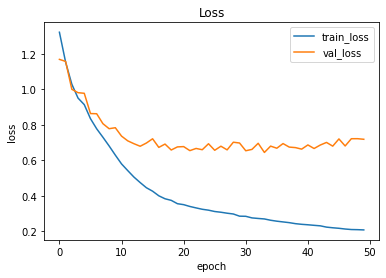

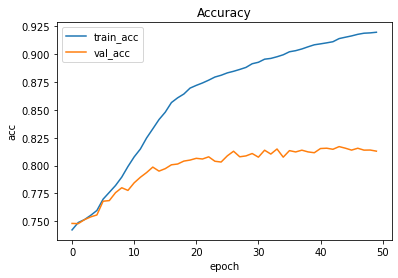

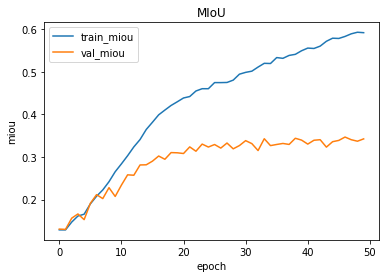

In [22]:
history = {'train_loss': train_loss_list, 'val_loss':val_loss_list,'train_miou': train_iou_list,
'val_miou':val_iou_list,'train_acc':train_acc_list,'val_acc':val_acc_list,'lr':lrs}
def plot_loss(history):
    plt.plot(history['train_loss'], label='train_loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.title('Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

def plot_miou(history):
    plt.plot(history['train_miou'], label='train_miou')
    plt.plot(history['val_miou'], label='val_miou')
    plt.title('MIoU')
    plt.xlabel('epoch')
    plt.ylabel('miou')
    plt.legend()
    plt.show()

def plot_acc(history):
    plt.plot(history['train_acc'], label='train_acc')
    plt.plot(history['val_acc'], label='val_acc')
    plt.title('Accuracy')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend()
    plt.show()
plot_loss(history)
plot_acc(history)
plot_miou(history)

In [23]:
best=torch.load('./models/FCN32-Vgg16.pt')

In [24]:
def decode_segmap(image, num_class=21):
    label_color = np.array([(0, 0, 0),
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, num_class):
        idx = image==l
        r[idx] = label_color[l,0]
        g[idx] = label_color[l,1]
        b[idx] = label_color[l,2]
    rgb =np.stack([r,g,b], axis=2)
    return rgb

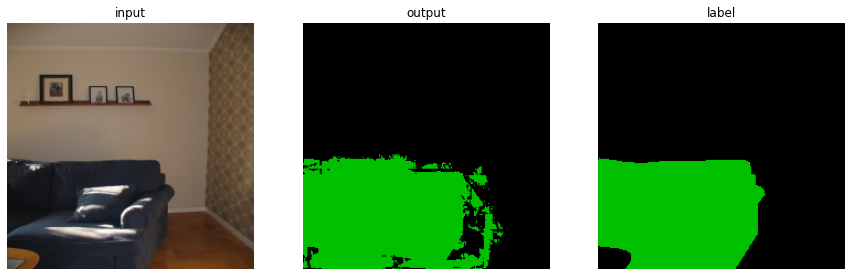

In [25]:
#img, label= train_set[0]
best.eval()
with torch.no_grad():
    for i, data in enumerate(train_loader):
        img, label = data
        
        best.to(device)
        #print(f'input shape:',img.shape)
        img = img.to(device)
        output = best(img)

        # tensor의 추적 제거 detach
        pred = torch.argmax(output[0], dim=0).detach().cpu().numpy()
        pred = decode_segmap(pred,21)
        
        img = img.squeeze() * torch.tensor(data_std).view(3, 1, 1).to(device)
        img = img + torch.tensor(data_mean).view(3, 1, 1).to(device)
        img = img[0].detach().cpu().numpy()
        img = img.transpose(1,2,0)

        label = label[0].detach().cpu().numpy()
        label = decode_segmap(label,21)

        plt.figure(figsize=(15,10))
        plt.subplot(1,3,1)
        plt.title('input')
        plt.axis('off')
        plt.imshow(img)
        plt.subplot(1,3,2)
        plt.title('output')
        plt.axis('off')
        plt.imshow(pred)
        plt.subplot(1,3,3)
        plt.title('label')
        plt.axis('off')
        plt.imshow(label)
        break


torch.Size([1, 3, 224, 224])


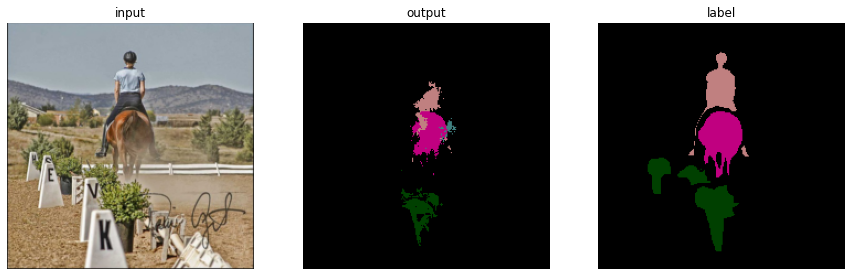

In [26]:
img, label= train_set[10]
best.eval()
#img = transform(img)
#label = val_transform(label)
best.to(device)
img=img.to(device)
label = label.to(device)
with torch.no_grad():
    
    img = img.unsqueeze(0)
    label = label.unsqueeze(0)
    output = best(img)
    pred = torch.argmax(output[0], dim=0).detach().cpu().numpy()
        
    pred = decode_segmap(pred,21)
    print(img.shape)
    img = img.squeeze() * torch.tensor(data_std).view(3, 1, 1).to(device)
    img = img + torch.tensor(data_mean).view(3, 1, 1).to(device)
    img = img.detach().cpu().numpy()
    img = img.transpose(1,2,0)

    label = label[0].detach().cpu().numpy()
    label = decode_segmap(label,21)
    
    plt.figure(figsize=(15,10))
    plt.subplot(1,3,1)
    plt.title('input')
    plt.axis('off')
    plt.imshow(img)
    plt.subplot(1,3,2)
    plt.title('output')
    plt.axis('off')
    plt.imshow(pred)
    plt.subplot(1,3,3)
    plt.title('label')
    plt.axis('off')
    plt.imshow(label)
    #break